# Is it going to rain tomorrow?

This project is for me to practice my machine learning chops while I'm in the early parts of my class. I'll be exploring the [Rain in Australia](https://www.kaggle.com/jsphyg/weather-dataset-rattle-package) Kaggle dataset and attempt to build a model to predict whether or not it will rain the next day for a given observation. Let's see how it goes!

In [1]:
threads = -1

In [2]:
import dill
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from functools import partial
from missingpy import MissForest
from scipy import stats
from tqdm.notebook import tqdm

from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve
from sklearn.model_selection import RandomizedSearchCV, cross_val_predict, cross_val_score, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer, LabelEncoder, OneHotEncoder, StandardScaler

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

/home/petya/.pyenv/versions/3.8.1/envs/rain-in-australia/lib/python3.8/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


## Exploring the data

First, we need to actually download the data. Thankfully Kaggle provides a helpful [API](https://github.com/Kaggle/kaggle-api). This will be installed as part of the `requirements.txt`.

In [3]:
%%bash

if ! [ -d "./data" ]; then
    mkdir ./data && cd ./data
    kaggle datasets download jsphyg/weather-dataset-rattle-package --unzip
fi

In [4]:
data = pd.read_csv("./data/weatherAUS.csv")
data.head()

Date Location  MinTemp  MaxTemp  Rainfall  Evaporation  Sunshine  \
0  2008-12-01   Albury     13.4     22.9       0.6          NaN       NaN   
1  2008-12-02   Albury      7.4     25.1       0.0          NaN       NaN   
2  2008-12-03   Albury     12.9     25.7       0.0          NaN       NaN   
3  2008-12-04   Albury      9.2     28.0       0.0          NaN       NaN   
4  2008-12-05   Albury     17.5     32.3       1.0          NaN       NaN   

  WindGustDir  WindGustSpeed WindDir9am  ... Humidity3pm  Pressure9am  \
0           W           44.0          W  ...        22.0       1007.7   
1         WNW           44.0        NNW  ...        25.0       1010.6   
2         WSW           46.0          W  ...        30.0       1007.6   
3          NE           24.0         SE  ...        16.0       1017.6   
4           W           41.0        ENE  ...        33.0       1010.8   

   Pressure3pm  Cloud9am  Cloud3pm  Temp9am  Temp3pm  RainToday  RISK_MM  \
0       1007.1       8.0       NaN     16.9     21.8         No      0.0   
1       1007.8       NaN       NaN     17.2     24.3         No      0.0   
2       1008.7       NaN       2.0     21.0     23.2         No      0.0   
3       1012.8       NaN       NaN     18.1     26.5         No      1.0   
4       1006.0       7.0       8.0     17.8     29.7         No      0.2   

   RainTomorrow  
0            No  
1            No  
2            No  
3            No  
4            No  

[5 rows x 24 columns]

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 142193 entries, 0 to 142192
Data columns (total 24 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Date           142193 non-null  object 
 1   Location       142193 non-null  object 
 2   MinTemp        141556 non-null  float64
 3   MaxTemp        141871 non-null  float64
 4   Rainfall       140787 non-null  float64
 5   Evaporation    81350 non-null   float64
 6   Sunshine       74377 non-null   float64
 7   WindGustDir    132863 non-null  object 
 8   WindGustSpeed  132923 non-null  float64
 9   WindDir9am     132180 non-null  object 
 10  WindDir3pm     138415 non-null  object 
 11  WindSpeed9am   140845 non-null  float64
 12  WindSpeed3pm   139563 non-null  float64
 13  Humidity9am    140419 non-null  float64
 14  Humidity3pm    138583 non-null  float64
 15  Pressure9am    128179 non-null  float64
 16  Pressure3pm    128212 non-null  float64
 17  Cloud9am       88536 non-null

Looks like `Evaporation`, `Sunshine`, `Cloud9am`, and `Cloud3pm` all have a lot of missing observations. I'm inclined to remove them since that's a decent chunk of data with some missing observations. But before I do that, let's just take a quick peak at how it relates to `RainTomorrow` just to see if there's any interesting relationship there.

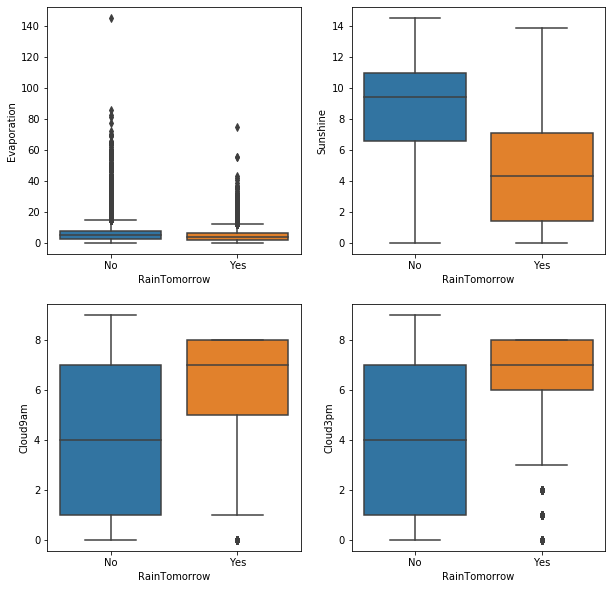

In [6]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))
sns.boxplot(x="RainTomorrow", y="Evaporation", data=data, ax=axs[0][0])
sns.boxplot(x="RainTomorrow", y="Sunshine", data=data, ax=axs[0][1])
sns.boxplot(x="RainTomorrow", y="Cloud9am", data=data, ax=axs[1][0])
sns.boxplot(x="RainTomorrow", y="Cloud3pm", data=data, ax=axs[1][1])
plt.show()

It looks like all of them seem to have a big impact on `RainTomorrow`, though it's hard to tell with `Evaporation` because of the wonky distribution. Let's do a test to compare the means of both groups to see. None of these variables look normal though, so we probably can't do a t-test, but let's take a closer look at the distribution of one case for fun.

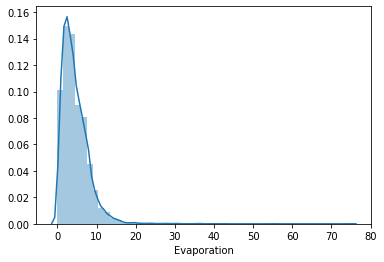

In [7]:
sns.distplot(data["Evaporation"][data["RainTomorrow"] == "Yes"])
plt.show()

That doesn't look quite normal to me, to further reinforce, we'll do a [D'Agostino-Pearson](https://en.wikipedia.org/wiki/D%27Agostino%27s_K-squared_test) test for normality.

In [8]:
stats.normaltest(data["Evaporation"][data["RainTomorrow"] == "No"].dropna())

NormaltestResult(statistic=56576.199472239765, pvalue=0.0)

Definitely not normal, as expected. So we can't do a t-test, but a common non-parametric alternative is the [Mann-Whitney U test](https://en.wikipedia.org/wiki/Mann%E2%80%93Whitney_U_test). So let's try that!

I was only interested in `Evaporation`, but might as well do all of them.

In [9]:
rain_yes = data[data["RainTomorrow"] == "Yes"]
rain_no = data[data["RainTomorrow"] == "No"]

def rain_tomorrow_mannwhitneyu_test(variable):
    return stats.mannwhitneyu(rain_yes[variable].dropna(), rain_no[variable].dropna())

print(f"""
Evaporation: {rain_tomorrow_mannwhitneyu_test('Evaporation')}
Sunshine: {rain_tomorrow_mannwhitneyu_test('Sunshine')}
Cloud9am: {rain_tomorrow_mannwhitneyu_test('Cloud9am')}
Cloud3pm: {rain_tomorrow_mannwhitneyu_test('Cloud3pm')}
""")


Evaporation: MannwhitneyuResult(statistic=458131994.0, pvalue=0.0)
Sunshine: MannwhitneyuResult(statistic=191164289.5, pvalue=0.0)
Cloud9am: MannwhitneyuResult(statistic=393444296.5, pvalue=0.0)
Cloud3pm: MannwhitneyuResult(statistic=310124259.0, pvalue=0.0)



Wow, those are some significant p-values. Just like I expected. Looks like `Evaporation` is also highly significant.

Since they are so important to determining `RainTomorrow`, I want to keep them in. During preparation, I can try imputing as well as dropping `NaN` rows.

I also want to know if and how imbalanced the data is.

In [10]:
data["RainTomorrow"].value_counts()

No     110316
Yes     31877
Name: RainTomorrow, dtype: int64

Very imbalanced, any model I make is likely to predict _No_ the majority of the time. Something to keep in mind.

In [11]:
data.describe()

MinTemp        MaxTemp       Rainfall   Evaporation  \
count  141556.000000  141871.000000  140787.000000  81350.000000   
mean       12.186400      23.226784       2.349974      5.469824   
std         6.403283       7.117618       8.465173      4.188537   
min        -8.500000      -4.800000       0.000000      0.000000   
25%         7.600000      17.900000       0.000000      2.600000   
50%        12.000000      22.600000       0.000000      4.800000   
75%        16.800000      28.200000       0.800000      7.400000   
max        33.900000      48.100000     371.000000    145.000000   

           Sunshine  WindGustSpeed   WindSpeed9am   WindSpeed3pm  \
count  74377.000000  132923.000000  140845.000000  139563.000000   
mean       7.624853      39.984292      14.001988      18.637576   
std        3.781525      13.588801       8.893337       8.803345   
min        0.000000       6.000000       0.000000       0.000000   
25%        4.900000      31.000000       7.000000      13.000000   
50%        8.500000      39.000000      13.000000      19.000000   
75%       10.600000      48.000000      19.000000      24.000000   
max       14.500000     135.000000     130.000000      87.000000   

         Humidity9am    Humidity3pm    Pressure9am    Pressure3pm  \
count  140419.000000  138583.000000  128179.000000  128212.000000   
mean       68.843810      51.482606    1017.653758    1015.258204   
std        19.051293      20.797772       7.105476       7.036677   
min         0.000000       0.000000     980.500000     977.100000   
25%        57.000000      37.000000    1012.900000    1010.400000   
50%        70.000000      52.000000    1017.600000    1015.200000   
75%        83.000000      66.000000    1022.400000    1020.000000   
max       100.000000     100.000000    1041.000000    1039.600000   

           Cloud9am      Cloud3pm        Temp9am        Temp3pm        RISK_MM  
count  88536.000000  85099.000000  141289.000000  139467.000000  142193.000000  
mean       4.437189      4.503167      16.987509      21.687235       2.360682  
std        2.887016      2.720633       6.492838       6.937594       8.477969  
min        0.000000      0.000000      -7.200000      -5.400000       0.000000  
25%        1.000000      2.000000      12.300000      16.600000       0.000000  
50%        5.000000      5.000000      16.700000      21.100000       0.000000  
75%        7.000000      7.000000      21.600000      26.400000       0.800000  
max        9.000000      9.000000      40.200000      46.700000     371.000000

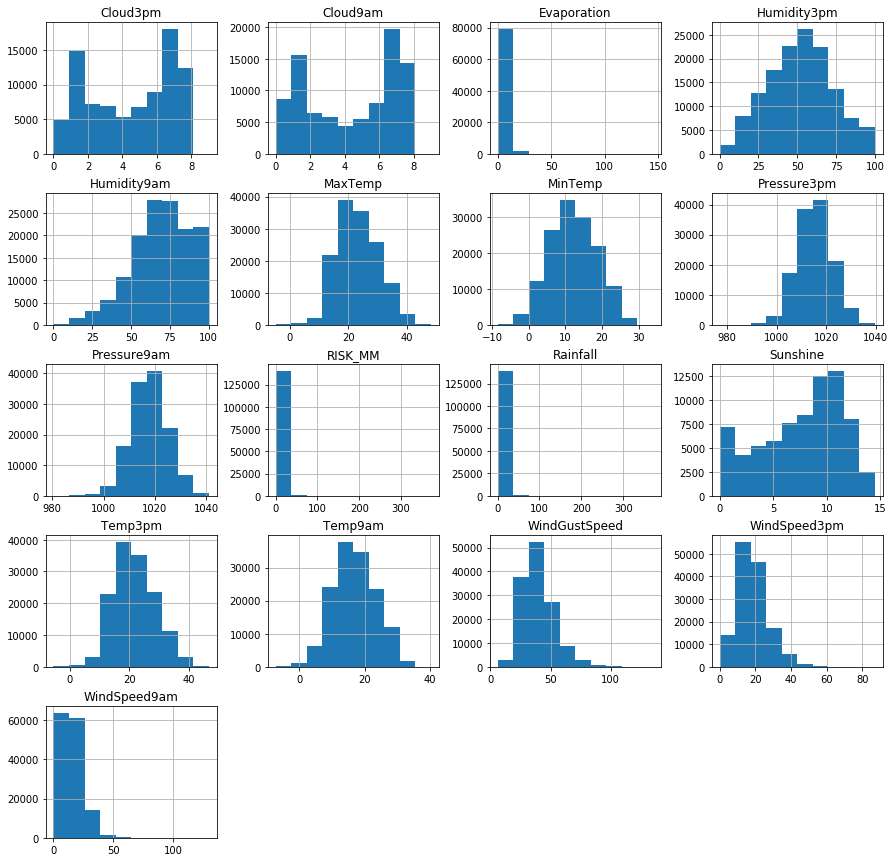

In [12]:
data.hist(figsize=(15,15))
plt.show()

CPU times: user 4min 43s, sys: 56.4 s, total: 5min 39s
Wall time: 4min


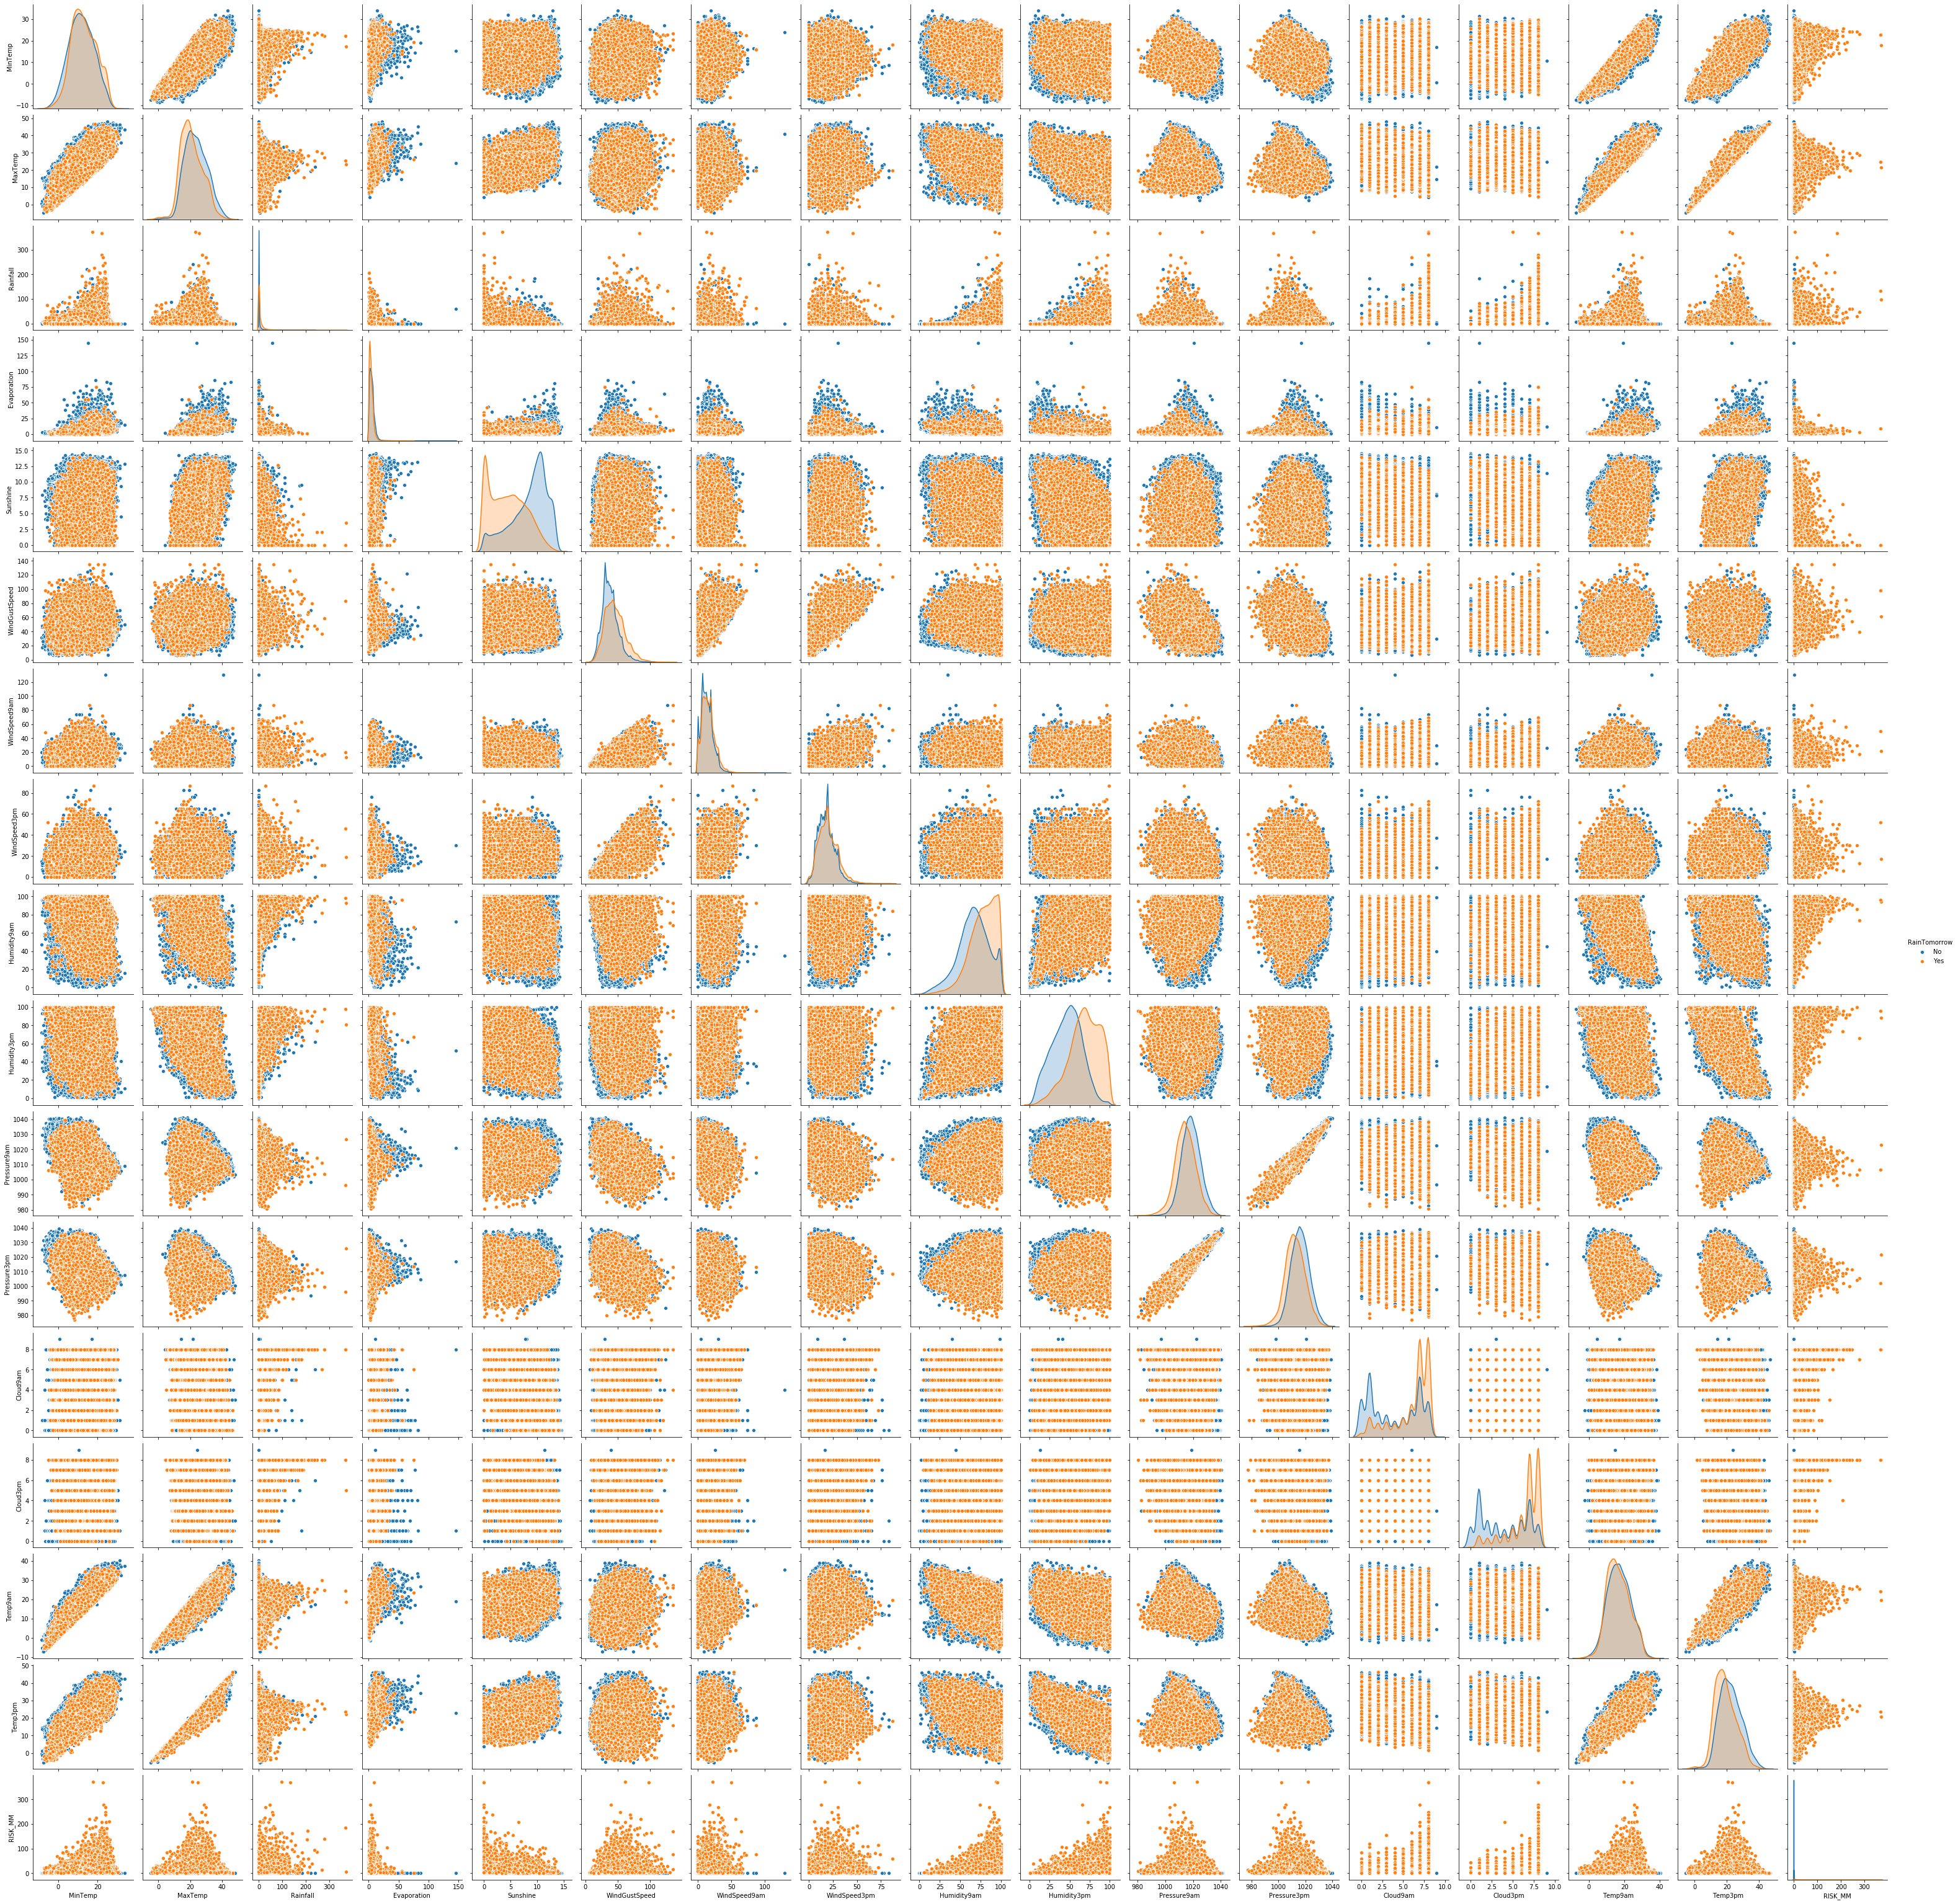

In [13]:
%%time

!mkdir -p ./images

pair_plot = sns.pairplot(data, hue="RainTomorrow")
pair_plot.savefig("./images/pairplot.png")

Although I can pick out some patterns from these scatter plots, it seems like `Evaporation` is the most powerful delineator in terms of `RainTomorrow`. I'll want to keep that in mind moving forward.

## Preparing the data

Ok, at this point I think I've done enough initial exploration and engineering. Let's go ahead and start preparing the data for machine learning and see how well it can perform.

Let's begin with a little feature engineering. One thing to note in particular is how a lot of these variables have a morning and evening variant. Let's make a new column for each of these to represent the change in said variable.

Another interesting feature could be how much `Evaporation` there was for how much `Sunshine` there was in a day. My intuition tells me that if there was a lot of `Evaporation` and not a lot of `Sunshine` (it was already a cloudy day), the chance of it raining would be higher.

Also if there was a lot of `Rainfall` and little `Sunshine`, it should continue to rain.

In [14]:
def engineer_features(columns, X):
    df = pd.DataFrame(X, columns=columns)
    
    df["ChangeInCloud"] = df["Cloud3pm"] - df["Cloud9am"]
    df["ChangeInHumidity"] = df["Humidity3pm"] - df["Humidity9am"]
    df["RangeOfTemp"] = df["MaxTemp"] - df["MinTemp"]
    df["ChangeInPressure"] = df["Pressure3pm"] - df["Pressure9am"]
    df["ChangeInTemp"] = df["Temp3pm"] - df["Temp9am"]
    df["ChangeInWindSpeed"] = df["WindSpeed3pm"] - df["WindSpeed9am"]
    
    df["EvaporationPerSunshine"] = df["Evaporation"] / df["Sunshine"]
    df["RainfallPerSunshine"] = df["Rainfall"] / df["Sunshine"]
    
    return df

Now I'll set up a pipeline for transforming the categorical and numeric variables accordingly.

It's worth noting this will drop `RISK_MM`. Discussion [here](https://www.kaggle.com/jsphyg/weather-dataset-rattle-package/discussion/78316) regarding `RISK_MM` as it involves data leakage.

For `Date`, I want to split it into month and day for two _"new"_ features.

In [15]:
def pipeline(estimator=None, imputer=(SimpleImputer(strategy="most_frequent"), SimpleImputer()), engineer=True):
    categorical_columns = ["Location", "WindGustDir", "WindDir9am", "WindDir3pm", "RainToday"]
    numeric_columns = ["MinTemp", "MaxTemp", "Rainfall", "Evaporation", "Sunshine", "WindGustSpeed", "WindSpeed9am", "WindSpeed3pm",
                       "Humidity9am", "Humidity3pm", "Pressure9am", "Pressure3pm", "Cloud9am", "Cloud3pm", "Temp9am", "Temp3pm"]

    date_transformer = Pipeline([
        ("split", FunctionTransformer(lambda s: s.str.split('-', expand=True).iloc[:, 1:])),
        ("imputer", imputer[0])
    ])
    
    categorical_transformer = Pipeline([
        ("imputer", imputer[0]),
        ("one_hot", OneHotEncoder(sparse=False))
    ])
    
    numeric_transformer = Pipeline(list(filter(None, [
        ("imputer", imputer[1]),
        ("add_one", FunctionTransformer(lambda X: X + 1)),
        ("engineer", FunctionTransformer(partial(engineer_features, numeric_columns))) if engineer else None,
        ("scaler", StandardScaler())
    ])))

    column_transformer = ColumnTransformer([
        ("date", date_transformer, "Date"),
        ("categorical", categorical_transformer, categorical_columns),
        ("numeric", numeric_transformer, numeric_columns)
    ])
    
    return Pipeline(list(filter(None, [
        ("preprocessor", column_transformer),
        ("estimator", estimator) if estimator is not None else None
    ])))

## Model selection

Great, I've set up our data preprocessing pipeline, now it's time to find a good model!

To begin, I'll need to split our data into a train and test set and preprocess them.

In [16]:
X_train, X_test, y_train, y_test = train_test_split(data, data["RainTomorrow"], test_size=0.2, stratify=data["RainTomorrow"])

In [17]:
y_preprocessor = LabelEncoder()
y_train_p = y_preprocessor.fit_transform(y_train)

Ok, I'll start by trying several different models on just the default parameters. Then I'll pick one to do some more in-depth training with. I'm only picking models which I have a deep understanding of at the time of this project. In the future, as I add new models to my repertoire, I could hopefully evaluate a lot more.

Before I begin it's important to pick a metric. In particular with predicting rainfall, we may be more interested in recall because failing to predict rain can have consequences. Of course this would depend on the problem we're trying to solve, and in the real world there would be a lot more work and discussion to figure it out, but for the purposes of this project I think recall wil do just fine.

Because I have an imbalanced dataset, I'll want to make sure to try and weight the classes as balanced where possible.

In [18]:
models = [
    RandomForestClassifier(class_weight="balanced"),
    Perceptron(class_weight="balanced"),
    SGDClassifier(class_weight="balanced"),
    KNeighborsClassifier(),
    DecisionTreeClassifier(class_weight="balanced"),
]

results = pd.DataFrame(columns=["Model", "Cross Validation Mean"])
for model in tqdm(models):
    avg_score = np.mean(cross_val_score(pipeline(model), X_train, y_train_p, scoring="recall", cv=10, n_jobs=threads, verbose=1))
    results.loc[len(results)] = [model.__class__.__name__, avg_score]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   49.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   12.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   18.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  2.4min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   16.3s finished


In [19]:
results.sort_values(by="Cross Validation Mean", ascending=False)

Model  Cross Validation Mean
2           SGDClassifier               0.753200
1              Perceptron               0.727255
4  DecisionTreeClassifier               0.531684
0  RandomForestClassifier               0.486393
3    KNeighborsClassifier               0.476276

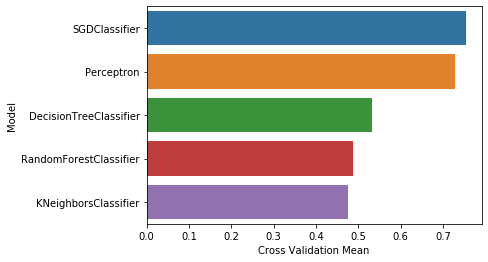

In [20]:
sns.barplot(x="Cross Validation Mean", y="Model", data=results.sort_values(by="Cross Validation Mean", ascending=False))
plt.show()

Looks like both SGD and perceptrons work well. I think I'll go with SGD since it can be implemented in perceptron's as well as other models. Before committing, I want to examine its precision and accuracy as well.

In [21]:
clf = pipeline(SGDClassifier(class_weight="balanced"))
y_pred = cross_val_predict(clf, X_train, y_train_p, cv=10, n_jobs=threads, verbose=1)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   17.8s finished


[(0, 'No'), (1, 'Yes')]


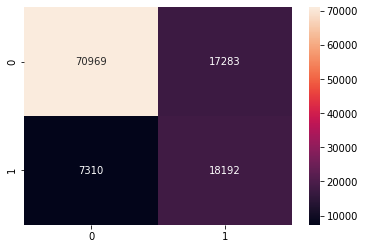

In [22]:
print(list(zip(y_preprocessor.transform(y_preprocessor.classes_), y_preprocessor.classes_)))
sns.heatmap(confusion_matrix(y_train_p, y_pred), annot=True, fmt="d")
plt.show()

In [23]:
print(classification_report(y_train_p, y_pred))

              precision    recall  f1-score   support

           0       0.91      0.80      0.85     88252
           1       0.51      0.71      0.60     25502

    accuracy                           0.78    113754
   macro avg       0.71      0.76      0.72    113754
weighted avg       0.82      0.78      0.80    113754



Not bad at all! I think I got a promising model on my hands. The precision is a little lower than I would like, but most importantly the recall is pretty good.

## Fine-tuning

Ok, so now I want to see what the effects of imputation and feature engineering have on this model. So I'm going to try re-preprocessing the data with and without each to see if there's an effect.

First, without imputing.

In [24]:
dropped = data.dropna()
X_train_d, X_test_d, y_train_d, y_test_d = train_test_split(dropped, dropped["RainTomorrow"], test_size=0.2, stratify=dropped["RainTomorrow"])
y_preprocessor_d = LabelEncoder()
y_train_d_p = y_preprocessor_d.fit_transform(y_train_d)
print("Number of observations:", X_train_d.shape[0])


clf_no_impute = pipeline(SGDClassifier(class_weight="balanced"))
y_pred_no_impute = cross_val_predict(clf_no_impute, X_train_d, y_train_d_p, cv=10, n_jobs=threads, verbose=1)
print(classification_report(y_train_d_p, y_pred_no_impute))

Number of observations: 45136


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


              precision    recall  f1-score   support

           0       0.92      0.83      0.87     35194
           1       0.55      0.76      0.64      9942

    accuracy                           0.81     45136
   macro avg       0.74      0.79      0.76     45136
weighted avg       0.84      0.81      0.82     45136



[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    4.8s finished


Now without engineering.

In [25]:
clf_no_engineer = pipeline(SGDClassifier(class_weight="balanced"), engineer=False)
y_pred_no_engineer = cross_val_predict(clf_no_engineer, X_train, y_train_p, cv=10, n_jobs=threads, verbose=1)
print(classification_report(y_train_p, y_pred_no_engineer))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


              precision    recall  f1-score   support

           0       0.92      0.77      0.84     88252
           1       0.49      0.77      0.60     25502

    accuracy                           0.77    113754
   macro avg       0.70      0.77      0.72    113754
weighted avg       0.82      0.77      0.78    113754



[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   17.3s finished


Now without either.

In [26]:
clf_neither = pipeline(SGDClassifier(class_weight="balanced"), engineer=False)
y_pred_neither = cross_val_predict(clf_neither, X_train_d, y_train_d_p, cv=10, n_jobs=threads, verbose=1)
print(classification_report(y_train_d_p, y_pred_neither))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


              precision    recall  f1-score   support

           0       0.92      0.83      0.87     35194
           1       0.55      0.74      0.63      9942

    accuracy                           0.81     45136
   macro avg       0.73      0.78      0.75     45136
weighted avg       0.84      0.81      0.82     45136



[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    4.7s finished


Looks like in each case accuracy was improved slightly at the cost of recall. Since I'm trying to maximize recall here without sacrificing precision too much, I'll keep both imputation and feature engineering in.

Also, I can try using a random forest to impute the data, however it is very slow. I'll see how well it works before committing to it. Hopefully, being able to keep a lot of data as well as better imputation will improve performance.

In [27]:
clf_test_rf = pipeline(SGDClassifier(class_weight="balanced"), imputer=(SimpleImputer(strategy="most_frequent"), MissForest(n_jobs=threads)))
y_pred_test_rf = cross_val_predict(clf_test_rf, X_train, y_train_p, cv=10, verbose=1)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 7
Iteration: 8
Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 7
Iteration: 8
Iteration: 9
Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 7
Iteration: 8
Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 7
Iteration: 8
Iteration: 9
Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 7
Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 7
Iteration: 8
Iteration: 9
Iteration: 0

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed: 253.9min finished


In [28]:
print(classification_report(y_train_p, y_pred_test_rf))

              precision    recall  f1-score   support

           0       0.92      0.80      0.86     88252
           1       0.52      0.76      0.62     25502

    accuracy                           0.79    113754
   macro avg       0.72      0.78      0.74    113754
weighted avg       0.83      0.79      0.80    113754



This seems to improve performance across the board for just a slight decrease in recall. I think this might be worth it, however I won't use this as a part of the parameter search and subsequent fine-tuning as it takes forever to do. I will just use this at the end for the final fit of the model.

### Parameter search

Ok, now I'll run my model through a randomized parameter search and optimize for recall and accuracy, but focusing more on recall.

In [29]:
param_distributions = {
    "estimator__loss" : ["hinge", "log", "modified_huber", "squared_hinge", "perceptron"],
    "estimator__penalty": ["l2", "l1", "elasticnet"],
    "estimator__alpha": stats.uniform(1e-6, 1e-2),
    "estimator__l1_ratio": stats.uniform(0, 1),
    "estimator__max_iter": np.geomspace(500, 10000, num=10),
    "estimator__tol": stats.uniform(1e-5, 1e-1),
    "estimator__learning_rate": ["constant", "optimal", "invscaling", "adaptive"],
    "estimator__eta0": stats.loguniform(1e-3, 1),
}

clf_rs = RandomizedSearchCV(pipeline(SGDClassifier(class_weight="balanced")), param_distributions, n_iter=1000, scoring=["recall", "accuracy"], cv=10, n_jobs=threads, refit=False, verbose=1)
clf_rs = clf_rs.fit(X_train, y_train_p)

Fitting 10 folds for each of 1000 candidates, totalling 10000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   54.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:  8.7min
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed: 17.4min
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed: 32.7min
[Parallel(n_jobs=-1)]: Done 1776 tasks      | elapsed: 54.6min
[Parallel(n_jobs=-1)]: Done 2426 tasks      | elapsed: 80.1min
[Parallel(n_jobs=-1)]: Done 3176 tasks      | elapsed: 124.1min
[Parallel(n_jobs=-1)]: Done 4026 tasks      | elapsed: 149.3min
[Parallel(n_jobs=-1)]: Done 4976 tasks      | elapsed: 170.6min
[Parallel(n_jobs=-1)]: Done 6026 tasks      | elapsed: 205.2min
[Parallel(n_jobs=-1)]: Done 7176 tasks      | elapsed: 231.3min
[Parallel(n_jobs=-1)]: Done 8426 tasks      | elapsed: 284.6min
[Parallel(n_jobs=-1)]: Done 9776 tasks      | elapsed: 334.4min
[Parallel(n_jobs=-1)]: Done 10000 out 

In [30]:
rs_results = pd.DataFrame(clf_rs.cv_results_, dtype=float)
rs_results = rs_results.melt(id_vars=[col for col in rs_results.columns if "param" in col]
                             , value_vars=["mean_test_recall", "mean_test_accuracy"], var_name="mean_test_type", value_name="mean_test_score")

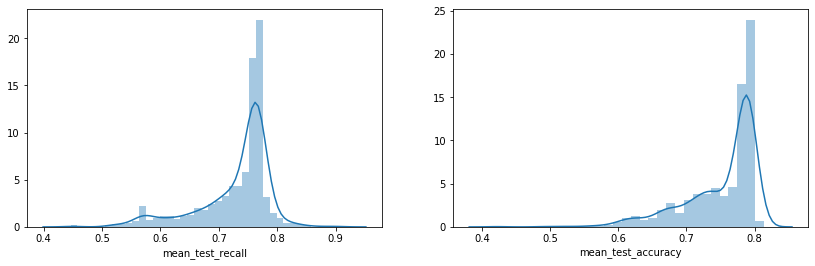

In [31]:
fig, axs = plt.subplots(ncols=2, figsize=(14, 4))
sns.distplot(rs_results[rs_results["mean_test_type"] == "mean_test_recall"]["mean_test_score"], ax=axs[0])
axs[0].set(xlabel="mean_test_recall")
sns.distplot(rs_results[rs_results["mean_test_type"] == "mean_test_accuracy"]["mean_test_score"], ax=axs[1])
axs[1].set(xlabel="mean_test_accuracy")
plt.show()

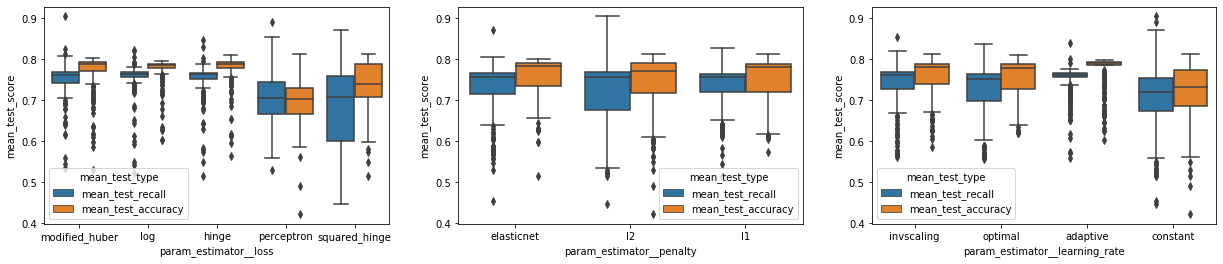

In [32]:
fig, axs = plt.subplots(ncols=3, figsize=(21, 4))
sns.boxplot(x="param_estimator__loss", y="mean_test_score", hue="mean_test_type", data=rs_results, ax=axs[0])
sns.boxplot(x="param_estimator__penalty", y="mean_test_score", hue="mean_test_type", data=rs_results, ax=axs[1])
sns.boxplot(x="param_estimator__learning_rate", y="mean_test_score", hue="mean_test_type", data=rs_results, ax=axs[2])
plt.show()

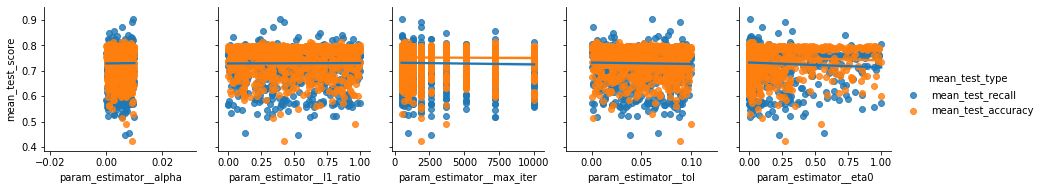

In [33]:
sns.pairplot(x_vars=["param_estimator__alpha", "param_estimator__l1_ratio", "param_estimator__max_iter", "param_estimator__tol", "param_estimator__eta0"],
             y_vars=["mean_test_score"], hue="mean_test_type", data=rs_results, kind="reg")
plt.show()

For `loss`, it looks like `"log"` is the best, which means I'll be using logistic regression. Although it does have a few gnarly outliers for recall score, I think that's acceptable.

`penalty` doesn't look like it changes much across the board, though I prefer the tighter distribution of `"elasticnet"`.

For `learning_rate`, `"adaptive"` works out the best with a fairly tight distribution. Though it is worth noting that when examining `eta0`, the recall score drops as `eta0` increases. Though the accuracy doesn't change much, so I'll go with a low value for that.

With most of my continuous parameters, it doesn't seem to have much an impact. I'll examine `alpha` further as it looks like there may be a strong relationship between that and the recall score. I'll want to try much higher values. Everything else looks like it can be left as default.

In [34]:
alpha_distribution = {"estimator__alpha": stats.uniform(1e-6, 1)}
set_parameters = {"class_weight": "balanced", "loss": "log", "penalty": "elasticnet", "learning_rate": "adaptive", "eta0": 1e-2}

clf_rs_alpha = RandomizedSearchCV(pipeline(SGDClassifier(**set_parameters)), alpha_distribution, n_iter=100, scoring=["recall", "accuracy"], cv=10, n_jobs=threads, refit=False, verbose=1)
clf_rs_alpha = clf_rs_alpha.fit(X_train, y_train_p)

Fitting 10 folds for each of 100 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   52.3s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:  9.1min
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed: 16.1min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed: 20.6min finished


In [35]:
rs_alpha_results = pd.DataFrame(clf_rs_alpha.cv_results_, dtype=float)
rs_alpha_results = rs_alpha_results.melt(id_vars=[col for col in rs_alpha_results.columns if "param" in col]
                             , value_vars=["mean_test_recall", "mean_test_accuracy"], var_name="mean_test_type", value_name="mean_test_score")

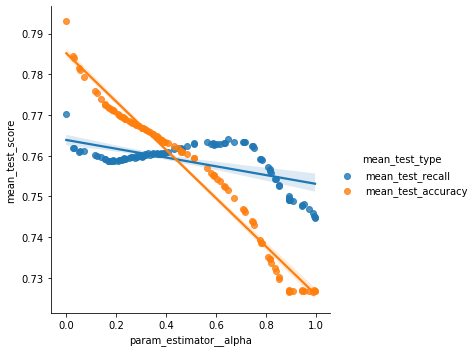

In [36]:
sns.lmplot(x="param_estimator__alpha", y="mean_test_score", hue="mean_test_type", data=rs_alpha_results)
plt.show()

Well that's funny. There's an extreme negative correlation with incrasing the alpha and accuracy that I couldn't see above.

I want to focus in on the low area to get a better look.

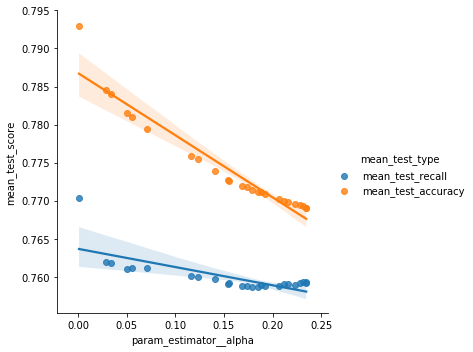

In [37]:
sns.lmplot(x="param_estimator__alpha", y="mean_test_score", hue="mean_test_type", data=rs_alpha_results[rs_alpha_results["param_estimator__alpha"] < 0.25])
plt.show()

Ok, there's basically a tradeoff here. Because recall doesn't increase by that much but accuracy does decrease by quite a lot as alpha increases, I'm willing to sacrifice a little bit of recall here considering it's still pretty high. The default, $1e^{-4}$ looks like a good a pick as any.

### Improving the recall

Now that I know the best parameters to use, I want to see if I can improve the recall without sacrificing accuracy too much. I'll start with plotting the precision-recall curve.

In [38]:
y_scores = cross_val_predict(pipeline(SGDClassifier(**set_parameters)), X_train, y_train_p, cv=10, n_jobs=threads, verbose=1, method="decision_function") 
precision, recall, thresholds = precision_recall_curve(y_train_p, y_scores)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   22.6s finished


/home/petya/.pyenv/versions/3.8.1/envs/rain-in-australia/lib/python3.8/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


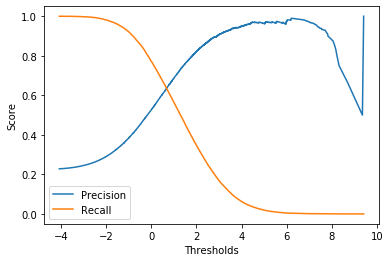

In [39]:
ax = sns.lineplot(thresholds, precision[:-1], label="Precision")
sns.lineplot(thresholds, recall[:-1], label="Recall", ax=ax)
ax.set(xlabel="Thresholds")
ax.set(ylabel="Score")
plt.show()

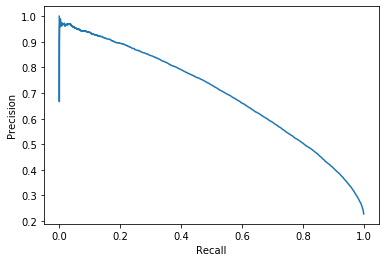

In [40]:
ax = sns.lineplot(recall, precision, ci=None)
ax.set(xlabel="Recall")
ax.set(ylabel="Precision")
plt.show()

It's not a great curve. There's not a clear point in which I can maximize both at reasonable values. I'll just have to live with it.

## Final fit and test

I think I've done about all I can do. I'll do a final fit of the data with the parameters I've found, and impute using random forests. Then I'll test it on the test set and see how well it goes!

In [41]:
%%time

clf_final = pipeline(SGDClassifier(**set_parameters), imputer=(SimpleImputer(strategy="most_frequent"), MissForest(n_jobs=threads)))
clf_final.fit(X_train, y_train_p)

Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 7
Iteration: 8
CPU times: user 3min 51s, sys: 2min 57s, total: 6min 49s
Wall time: 26min


Pipeline(memory=None,
         steps=[('preprocessor',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('date',
                                                  Pipeline(memory=None,
                                                           steps=[('split',
                                                                   FunctionTransformer(accept_sparse=False,
                                                                                       check_inverse=True,
                                                                                       func=<function pipeline.<locals>.<lambda> at 0x7fad0fb2b550>,
                                                                                       inv_kw_args=None,
                                                                                      

In [42]:
%%time

y_pred_final = clf_final.predict(X_test)

Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
CPU times: user 31.2 s, sys: 22 s, total: 53.2 s
Wall time: 3min 40s


In [43]:
y_test_p = y_preprocessor.transform(y_test)
print(classification_report(y_train_p, y_pred_test_rf))

              precision    recall  f1-score   support

           0       0.92      0.80      0.86     88252
           1       0.52      0.76      0.62     25502

    accuracy                           0.79    113754
   macro avg       0.72      0.78      0.74    113754
weighted avg       0.83      0.79      0.80    113754



$79\%$ accuracy at $76\%$ recall on the test set. Not bad at all! It's not going to put any weathermen out of business in Australia, but it's certainly respectable.

## Conclusions

### What I've learned

* Perform a train/test split before doing EDA.
* Perform more EDA to gain more insight into relationships between variables.
* Make options for pipeline parameters so they can be included as part of the parameter search.
* Consider an ensemble method like a voting classifier.
* Try more models, and maybe even a neural network.
* It's clear I have a good understanding of preprocessing and model building; but I lack in the realm of EDA and feature engineering. In the future I'll focus on that more, as I think with a bit of extra work on that end, my model could be a lot better.
* No need to rerun the whole notebook before finishing, just include the session in the repository in the future.

In [44]:
dill.dump_session("rain.db")

In [45]:
dill.load_session("rain.db")